In [17]:
import pandas as pd
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from google.cloud.language_v2 import types
from google.oauth2 import service_account
from google.cloud import language_v2
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

tqdm.pandas()

google_creds = service_account.Credentials.from_service_account_file("/Users/gustavelapierre/Downloads/x.json")
google = language_v2.LanguageServiceClient(credentials=google_creds, )
output_file_path = '../data/beer_reviews_text.csv'
df = pd.read_csv(output_file_path, nrows=100)
df.head()

,text
0,"Puszka 0,33l dzięki Christoph . Kolor jasnozło..."
1,Cerveza pale lager gabonesa. MÃ¡s floja que la...
2,"Kolor- złoty, klarowny. Piana - drobna, średni..."
3,"Botella, de GabÃ³n regalo familiar.31/01/2015C..."
4,Many thanks for this beer to Erzengel. Pours l...


In [18]:
def google_sentiment_scores(txt):
        document = {"content": txt, "type": language_v2.types.Document.Type.PLAIN_TEXT}
        response = google.analyze_sentiment(request={"document": document})
        return response.document_sentiment.score

In [19]:
def classify_per_sentiment(score):
    """
    Method discretizing a sentiment score into one of 5 classes.
    :param score: (float): number to discretize
    :return: (float) within {-2,-1,0,1,2}, discretion sentiment score
    """

    if score < -0.5:
        return -2
    elif score < -0.1:
        return -1
    elif -0.1 <= score <= 0.1:
        return 0
    elif score <= 0.5:
        return 1
    elif score > 0.5:
        return 2
    else:
        return 0

In [20]:
class SentimentAnalysisModel:
    def __init__(self, model_path='multilingual-sentiment', weights=None):
        if weights is not None:
            self.weights = weights
        else:
            self.weights = torch.tensor([[-1, -0.5, 0, 0.5, 1]]).unsqueeze(0).unsqueeze(-1)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_path)
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
    
    def forward(self, **inputs):
        """
        :param inputs: Inputs of the bert-base-multilingual
        :return: sentiment score ranging from -1 to 1.
        """

        with torch.no_grad():
            outputs = self.model(**inputs)
        predictions = outputs.logits
        probabilities = torch.softmax(predictions, dim=-1)
        obtained_sentiment = torch.matmul(probabilities, self.weights).squeeze().unsqueeze(0)
        return obtained_sentiment

# Initialize model
sentiment_model = SentimentAnalysisModel(model_path="../models/sentiment_model", weights=None)

# Tokenize comments
tokenized_comments = sentiment_model.tokenizer(
    df.iloc[:, 0].astype(str).tolist(),
    return_tensors='pt',
    padding=True,
    truncation=True,
    max_length=512
)

# Convert tokenized data to DataFrame
tokenized_comments_df = pd.DataFrame(
    {key: val.tolist() for key, val in tokenized_comments.items()}
)

# Calculate sentiment scores
df['sentiment_local'] = tokenized_comments_df.apply(
    lambda row: sentiment_model.forward(
        **{k: v[row.name].unsqueeze(0) for k, v in tokenized_comments.items()}
    ).item(),
    axis=1
).values

# Classify sentiments
df['class_sentiment_local'] = df['sentiment_local'].apply(lambda sentiment: classify_per_sentiment(sentiment))

In [21]:
df['sentiment_google'] = df.iloc[:100, 0].progress_apply(lambda txt: google_sentiment_scores(txt))
df['class_sentiment_google'] = df['sentiment_google'].apply(lambda sentiment: classify_per_sentiment(sentiment))

100%|██████████| 100/100 [00:48<00:00,  2.04it/s]


In [22]:
df.head(10)

,text,sentiment_local,class_sentiment_local,sentiment_google,class_sentiment_google
0,"Puszka 0,33l dzięki Christoph . Kolor jasnozło...",0.264219,1,0.466,1
1,Cerveza pale lager gabonesa. MÃ¡s floja que la...,-0.433953,-1,-0.435,-1
2,"Kolor- złoty, klarowny. Piana - drobna, średni...",0.146838,1,0.011,0
3,"Botella, de GabÃ³n regalo familiar.31/01/2015C...",-0.067187,0,0.027,0
4,Many thanks for this beer to Erzengel. Pours l...,0.841719,2,0.634,2
5,Many thanks to Erzengel for sharing! Pours cle...,0.687191,2,0.063,0
6,Many thanks to Travlr for this can! Grainy no...,0.763474,2,0.416,1
7,"Puszka pita w Gabonie. Kolor jasnosłomkowy, pi...",0.025440,0,0.156,1
8,"330ml bottle. 29-05-2014.From Gabon, courtesy ...",-0.610939,-2,-0.099,0
9,Light yellow with quickly disappearing foam to...,-0.171505,-1,-0.189,-1


In [23]:
# 0: "0.33l can, thanks Christoph. Light golden color, fine-grained white foam falls quickly. Malt aroma, slightly sweet. Quite good."
# 1: "Gabonese pale lager beer. Weaker than Regab. Scant aroma, pale appearance, very little body and little aftertaste on the palate. If I ever went to Gabon I would order one more to try it again and the rest of time the Regab would undoubtedly ask for, which is not anything special, but it is superior to this one.
# 2: "Color - golden, clear. Foam - fine, medium high, not persistent. Smell - light malty. Taste - light malt and hops, light sour, light sweetness and bitterness"
# 3: "Bottle, from Gabon as a family gift. 01/31/2015Yellow color, aromas and flavors of corn, medium body"
# 4: "Many thanks for this beer to Erzengel. Pours light golden with medium head. Light bodied crisp taste with low carbonation. Sweet finish."


In [24]:
exact_match = (df['class_sentiment_local'] == df['class_sentiment_google']).mean() * 100
print("exact_match : " + str(exact_match))

exact_match : 46.0


In [25]:
margin_match = (df['class_sentiment_local'] - df['class_sentiment_google']).abs() <= 1
margin_match_percentage = margin_match.mean() * 100
print("margin match : " + str(margin_match_percentage))

margin match : 79.0


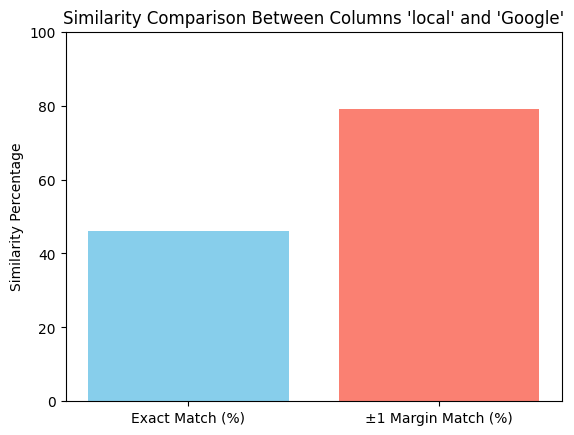

In [26]:
similarity_data = {
    'Exact Match (%)': exact_match,
    '±1 Margin Match (%)': margin_match_percentage
}

fig, ax = plt.subplots()
ax.bar(similarity_data.keys(), similarity_data.values(), color=['skyblue', 'salmon'])
ax.set_ylabel("Similarity Percentage")
ax.set_ylim(0, 100)
plt.title("Similarity Comparison Between Columns 'local' and 'Google'")
plt.show()